In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

In [16]:
main_labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
labels_list = []

for class_dir in os.listdir("data/train"):
    labels_list += [main_labels.index(class_dir) if class_dir in main_labels else 10 for label in os.listdir(os.path.join("data/train", class_dir))]


train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="data/train",
    labels=labels_list,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')


Found 64727 files belonging to 11 classes.
Using 51782 files for training.
Using 12945 files for validation.


In [17]:
label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)



label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10']


In [19]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


In [152]:
def preprocess_data_into_specs(ds):

  nfft=512
  window=512
  stride=256
  rate=16000
  mels=128
  fmin=0 
  fmax=8000
  top_db=80

  spect_ds = ds.map(
      map_func=lambda audio,label: (tfio.audio.spectrogram(audio, nfft=nfft, window=window, stride=stride), label),
      num_parallel_calls=tf.data.AUTOTUNE)
  mel_spect_ds = spect_ds.map(
    map_func=lambda audio, label: (tfio.audio.melscale(audio, rate=rate, mels=mels, fmin=fmin, fmax=fmax), label),
    num_parallel_calls=tf.data.AUTOTUNE
  )
  return mel_spect_ds.map(
      map_func=lambda audio,label: (tfio.audio.dbscale(audio, top_db=top_db), label),
      num_parallel_calls=tf.data.AUTOTUNE)


In [153]:
spec_train_ds = preprocess_data_into_specs(train_ds)
spec_val_ds = preprocess_data_into_specs(val_ds)

In [154]:
for example_spec_audio, example_spec_labels in spec_train_ds.take(1):
    print(example_spec_audio.shape)

(64, 63, 128)


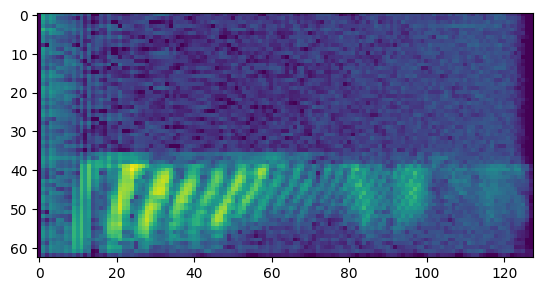

In [156]:
plt.imshow(example_spec_audio[25].numpy())
plt.show() 

In [157]:
input_shape=(63,128)
model = tf.keras.Sequential()
model.add(LSTM(128,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(11, activation='softmax'))
model.summary()

# layers.Bidirectional(layers.LSTM(20), merge_mode="sum")

c:\Users\lukgr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,283 (555.79 KB)

 Trainable params: 142,283 (555.79 KB)

 Non-trainable params: 0 (0.00 B)

In [158]:
train_spectrogram_ds = spec_train_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = spec_val_ds.cache().prefetch(tf.data.AUTOTUNE)


In [159]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(train_spectrogram_ds, epochs=50, validation_data=val_spectrogram_ds)